In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
#bempp.api.enable_console_logging()

In [2]:
help(bempp.api.shapes.sphere)

Help on function sphere in module bempp.api.shapes.shapes:

sphere(r=1, origin=(0, 0, 0), h=0.1)
    Return a sphere grid.
    
    Parameters
    ----------
    r : float
        Radius of the sphere.
    origin : tuple
        Center of the sphere.
    h : float
        Element size.



Sphere-Sphere case 

In [2]:
h = .2   # size of the mesh (element)
center1 = (2, 0, 0) # center of one sphere
center2 = (-2, 0, 0) # center of the other sphere

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

In [3]:
def get_box(nx, ny, mat, nboxes, n):
    """Return the content of a given box"""
    size = n//nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [5]:
def get_con_box(i,mat,nboxes,n):
    BB = mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [6]:
def L(i,k,mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [7]:
def index_set(k,mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,mat,nboxes,n)[1][0:k])
    return l

In [8]:
def S(k,mat,nboxes,n):
    ll = index_set(k,mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [9]:
def R(i,k,mat,nboxes,n):
    RR = np.transpose(L(i,k,mat,nboxes,n)[0])
    return RR

In [10]:
def new_S(k,mat,nboxes,n):
    mat_ = S(k,mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,mat,nboxes,n) @ np.linalg.inv(get_box(i,i,mat,nboxes,n)) @ L(i,k,mat,nboxes,n)[0])
    return mat_

In [11]:
def logdet_(k,mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,mat,nboxes,n)@np.linalg.inv(get_box(i,i,mat,nboxes,n)) @L(i,k,mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [24]:
N = 10
lbound = .05
ubound = 4

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64')
results_appro1 = np.empty((20,N), dtype='float64')


for index, point in enumerate(quad_points):

    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22

    mat1 = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
    combined = np.linalg.inv(mat2).dot(mat1)
    sign, logdet = slogdet(combined)
    results[index] = logdet

    n = combined.shape[0]
    nboxes = 33
    for rk in range(1,21):
        results_appro1[rk-1,index] = logdet_(rk,combined,nboxes,n)

In [25]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)

casimir_energy_appro = np.empty(20, dtype='float64')

for i in range(20):
    casimir_energy_appro[i] = np.trapz(-results_appro1[i,:] / quad_points, quad_points) / (2 * np.pi)   

In [26]:
relative_error_logdet = np.empty(20, dtype='float64')
for i in range(20):
    relative_error_logdet[i] = (casimir_energy - casimir_energy_appro[i])/casimir_energy

In [28]:
num = np.linspace(1,N,N)

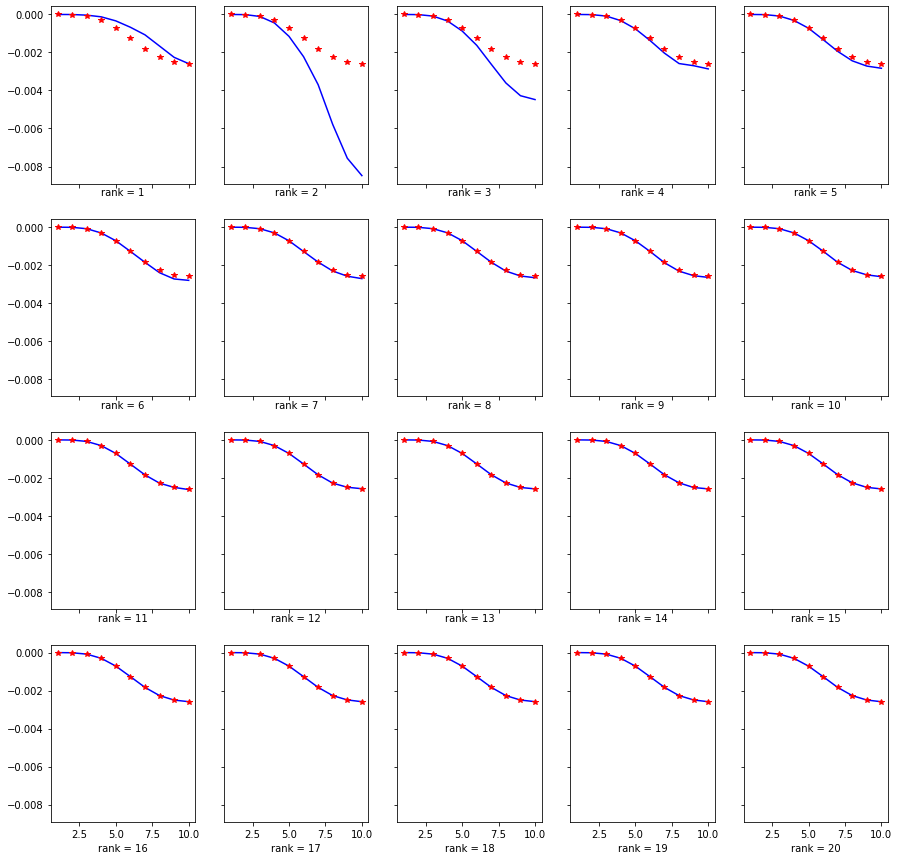

In [37]:
fig, axes = plt.subplots(4,5, sharex=True, sharey=True)
"""Compare the approximate logdet of the matrix obtained under different wavenumbers using different rank and compare them with the exact value"""
for i, ax in enumerate(axes.flatten()):
    ax.plot(num, results_appro1[i,:],color='blue') #color=next(palette)
    ax.plot(num,results,'r*')
    ax.set_xlabel('rank = {0}'.format(i+1) )
    plt.rcParams['figure.figsize'] = [15,15]
plt.show()

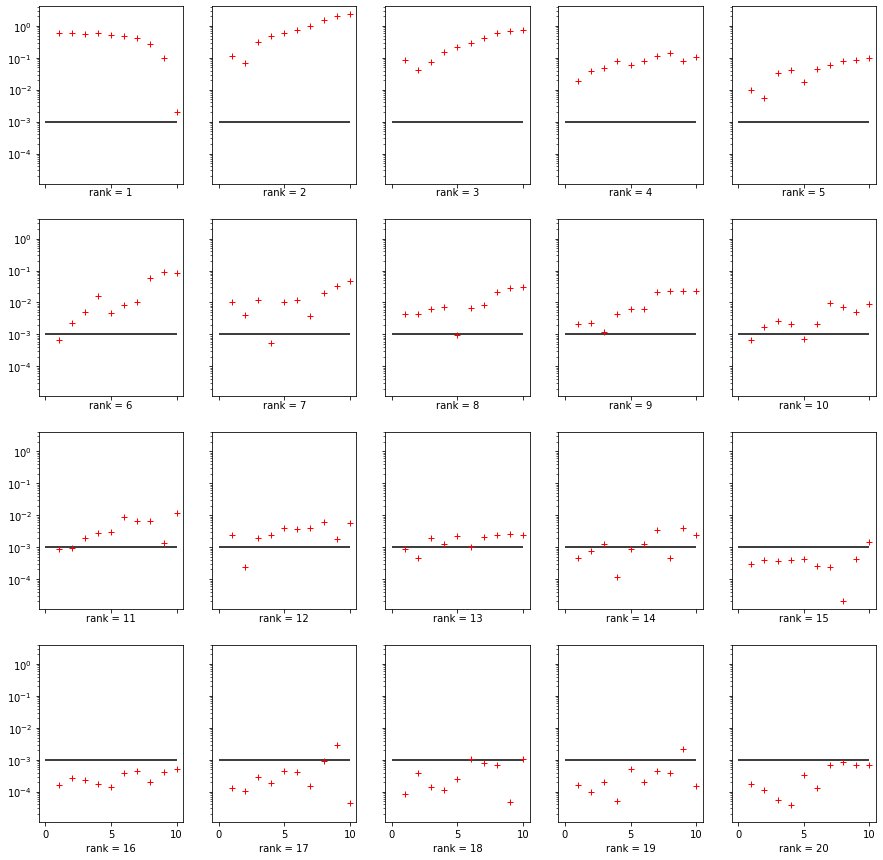

In [38]:
fig, axes = plt.subplots(4,5, sharex=True, sharey=True)
"""relative error between above points"""
for i, ax in enumerate(axes.flatten()):
    ax.semilogy(num, abs((results - results_appro1[i,:])/results),'r+')
    ax.set_xlabel('rank = {0}'.format(i+1) )
    ax.hlines(0.001, 0, 10, colors = 'k') 
    plt.rcParams['figure.figsize'] = [15,15]
plt.show()

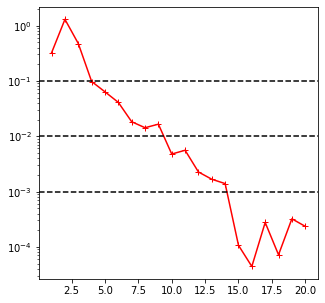

In [72]:
rank = np.linspace(1,20,20)
plt.semilogy(rank, abs(relative_error_logdet),'r+-')
plt.rcParams['figure.figsize'] = [5,5]

plt.axhline(y=0.1, color = 'k',linestyle='--')
plt.axhline(y=0.01, color = 'k',linestyle='--')
plt.axhline(y=0.001, color = 'k',linestyle='--')

plt.show()

In [53]:
results2 = np.empty(N, dtype='float64')
results_appro2 = np.empty((20,N), dtype='float64')


for index, point in enumerate(quad_points):

    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22

    mat1 = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
    combined = np.linalg.inv(mat2).dot(mat1)
    sign, logdet = slogdet(combined)
    results2[index] = logdet

    n = combined.shape[0]
    nboxes = 33
    for rk in range(21,41):
        results_appro2[rk-21,index] = logdet_(rk,combined,nboxes,n)

In [54]:
casimir_energy_appro2 = np.empty(20, dtype='float64')

for i in range(20):
    casimir_energy_appro2[i] = np.trapz(-results_appro2[i,:] / quad_points, quad_points) / (2 * np.pi)   

In [55]:
relative_error_logdet2 = np.empty(20, dtype='float64')
for i in range(20):
    relative_error_logdet2[i] = (casimir_energy - casimir_energy_appro2[i])/casimir_energy

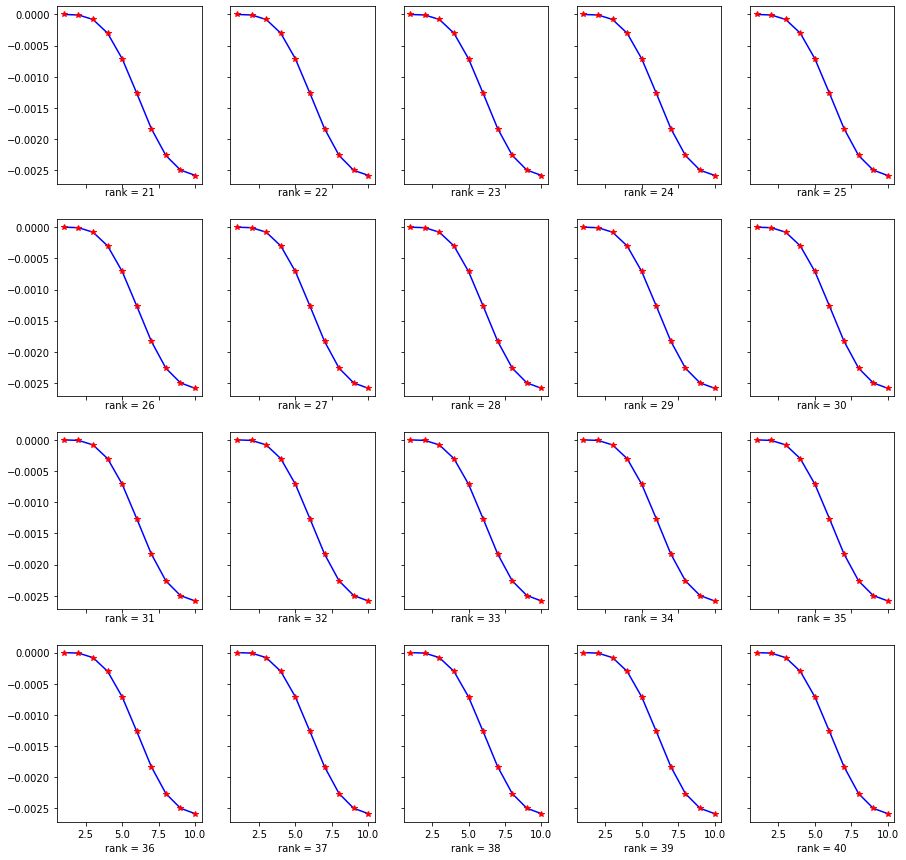

In [62]:
fig2, axes2 = plt.subplots(4,5, sharex=True, sharey=True)
"""relative error between above points"""
for i, ax in enumerate(axes2.flatten()):
    ax.plot(num, results_appro2[i,:],color='blue') #color=next(palette)
    ax.plot(num,results2,'r*')
    ax.set_xlabel('rank = {0}'.format(i+21))
    #ax.hlines(0.001, 0, 10, colors = 'k') 
    plt.rcParams['figure.figsize'] = [15,15]
plt.show()

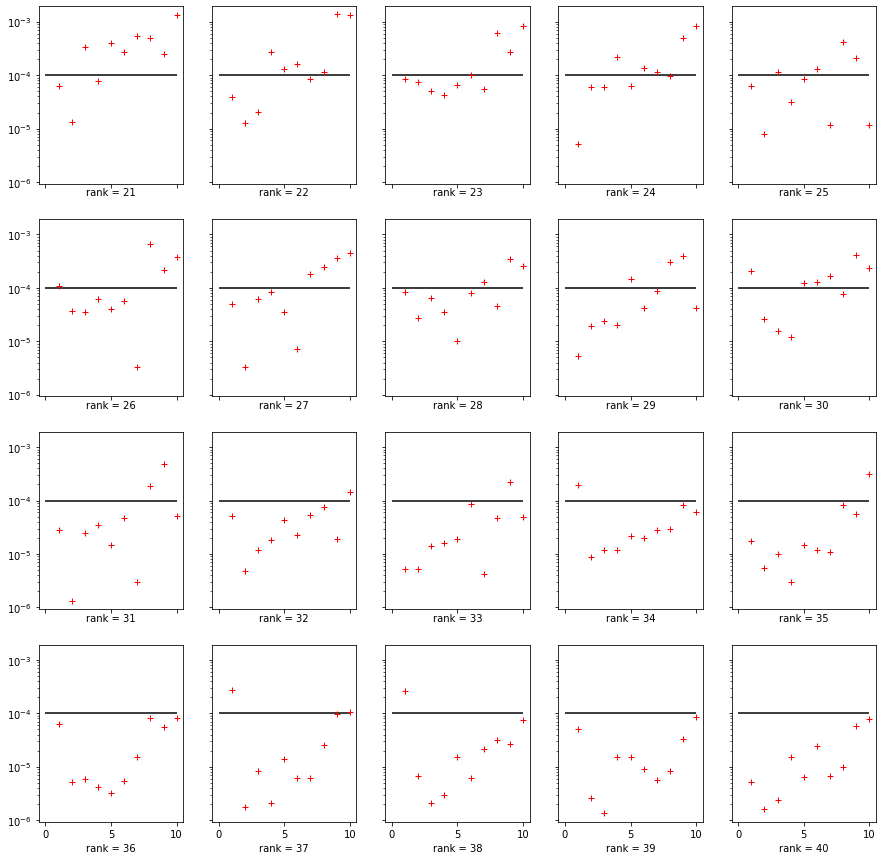

In [65]:
fig2, axes2 = plt.subplots(4,5, sharex=True, sharey=True)
"""relative error between above points"""
for i, ax in enumerate(axes2.flatten()):
    ax.semilogy(num, abs((results2 - results_appro2[i,:])/results2),'r+')
    ax.set_xlabel('rank = {0}'.format(i+21) )
    ax.hlines(0.0001, 0, 10, colors = 'k') 
    plt.rcParams['figure.figsize'] = [15,15]
plt.show()

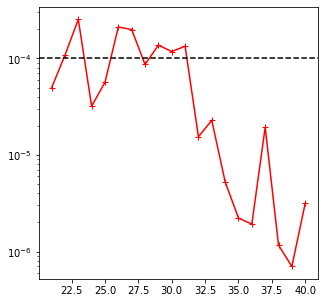

In [69]:
rank = np.linspace(21,40,20)
plt.semilogy(rank, abs(relative_error_logdet2),'r+-')
plt.rcParams['figure.figsize'] = [5,5]
plt.axhline(y=0.0001, color = 'k',linestyle='--')

plt.show()

In [ ]:
results3 = np.empty(N, dtype='float64')
results_appro3 = np.empty((20,N), dtype='float64')


for index, point in enumerate(quad_points):

    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22

    mat1 = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
    combined = np.linalg.inv(mat2).dot(mat1)
    sign, logdet = slogdet(combined)
    results3[index] = logdet

    n = combined.shape[0]
    nboxes = 33
    for rk in range(41,61):
        results_appro3[rk-41,index] = logdet_(rk,combined,nboxes,n)